### Preface: this study is stage 3 in the development of a project on cryptocurrencies and step 3 in clustering.

import required libs

In [388]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from tqdm.autonotebook import tqdm
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster 

from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters, EfficientFCParameters
from sklearn.decomposition import PCA
from dtaidistance import clustering, dtw

from sklearn.svm import OneClassSVM
from numpy import where
from datetime import timedelta

In [389]:
def get_info(ticker_obj):
    info_keys = ['shortName']
    info_values = []
    for key in info_keys:
        info_values.append(ticker_obj.info.get(key, None))
    return dict(zip(info_keys, info_values))

Upload the data using the functions from the first stage

In [390]:
interesting_tickers = ['BTC-USD','ETH-USD', 'BNB-USD', 'ADA-USD', 'DOGE-USD', 'SHIB-USD', 'LTC-USD', 'ETC-USD', 
           'BCH-USD', 'VET-USD', 'FIL-USD', 'SNX-USD', 'KAVA-USD', 'TWT-USD', 'KSM-USD', 'YFI-USD',
          'UTK-USD', 'RPL-USD', 'SOL-USD', '1INCH-USD', 'THETA-USD', 'OCEAN-USD', 'CHR-USD', 'WRX-USD',
          'DENT-USD', 'DNT-USD', 'CRV-USD', 'DOT-USD', 'KEY-USD', 'BEAM-USD', 'MATIC-USD', 'HEX-USD',
           'AAVE-USD', 'EGLD-USD', 'BTT-USD', 'CAKE-USD', 'HNT-USD', 'DASH-USD', 'ZIL-USD','XDC-USD',
           'KSM-USD','CEL-USD', 'QTUM-USD', 'GLM-USD', 'WAXP-USD', 'NFLX-USD', 'QNT-USD', 'AAPL-USD',
          'NVDA-USD', 'GOOGL-USD']
load = False

if load:
    full_ticker_data = []
    for ticker in tqdm(interesting_tickers):
        try:
            ticker_obj = yf.Ticker(ticker)
            close_price = ticker_obj.history(period='1y', interval='1d')['Close'].to_dict()
            info = get_info(ticker_obj)
            info.update(close_price)
            full_ticker_data.append(info)
        except Exception as e:
            print(e)
            continue
        
    full_ticker_df_0 = pd.DataFrame(full_ticker_data)
    full_ticker_df = pd.DataFrame(full_ticker_df_0.iloc[:,1:].pct_change(axis='columns'))
    full_ticker_df.insert(0, "shortName", full_ticker_df_0.shortName)
    full_ticker_df.to_csv("full_ticker_df_month_01_2022.csv")

else: 
    full_ticker_df = pd.read_csv("full_ticker_df_month_01_2022.csv", index_col=0)
    datetime_columns = pd.to_datetime(full_ticker_df.columns[5:])
    full_ticker_df.columns = list(full_ticker_df.columns[:5]) + list(datetime_columns)

Prepare the data using the code from the first step

In [393]:
full_ticker_df = full_ticker_df.iloc[:, :-1]
prices = full_ticker_df.iloc[:, 5:].T
prices = prices.fillna(method='backfill')
prices = prices.fillna(method='ffill')
full_ticker_df = full_ticker_df.iloc[:, :5].join(prices.T)

In [394]:
scaler = StandardScaler()
tickers_scaled = scaler.fit_transform(full_ticker_df.iloc[:, 5:].T).T

In [395]:
tickers_scaled_2_df = pd.DataFrame(tickers_scaled, index=full_ticker_df.shortName, columns=full_ticker_df.iloc[:,:-5].columns).drop(columns='shortName')
tickers_scaled_2_df.head()

2021-10-06 00:00:00  2021-10-07 00:00:00  2021-10-08 00:00:00  \
shortName                                                                     
Bitcoin USD              1.517292            -0.672519             0.776083   
Ethereum USD             0.826881            -0.297973             0.773816   
BNB USD                  0.551642             1.941979             1.600231   
Cardano USD             -0.152609            -0.440983             0.743761   
Dogecoin USD             0.202115            -0.413289             0.622884   

              2021-10-09 00:00:00  2021-10-10 00:00:00  2021-10-11 00:00:00  \
shortName                                                                     
Bitcoin USD              0.023531             2.250562            -0.270017   
Ethereum USD             1.165445             0.495900            -0.150220   
BNB USD                  0.078070             0.100591            -0.440688   
Cardano USD             -0.105442             0.486759            -0.272011   
Dogecoin USD             0.024845             0.183881             0.357940   

              2021-10-12 00:00:00  2021-10-13 00:00:00  2021-10-14 00:00:00  \
shortName                                                                     
Bitcoin USD              0.382831             0.289349             1.121614   
Ethereum USD             0.137170            -0.539261             0.815581   
BNB USD                  0.288478             0.816675             0.171688   
Cardano USD             -0.125704            -0.202993            -0.077850   
Dogecoin USD             0.103307             0.857125            -0.072266   

              2021-10-15 00:00:00  ...  2022-09-21 00:00:00  \
shortName                          ...                        
Bitcoin USD              0.854273  ...             0.720345   
Ethereum USD             1.660840  ...             0.756300   
BNB USD                  0.700624  ...             0.186124   
Cardano USD              0.776009  ...             0.095339   
Dogecoin USD             0.741623  ...             0.030066   

              2022-09-22 00:00:00  2022-09-23 00:00:00  2022-09-24 00:00:00  \
shortName                                                                     
Bitcoin USD             -0.106906             0.549505             0.285149   
Ethereum USD            -0.049388             0.162254             0.008781   
BNB USD                 -0.329262             0.912804             0.194399   
Cardano USD             -0.153648            -0.143740             0.110421   
Dogecoin USD            -0.109452             0.055839             0.086512   

              2022-09-25 00:00:00  2022-09-26 00:00:00  2022-09-27 00:00:00  \
shortName                                                                     
Bitcoin USD             -0.147510            -0.116490            -0.342859   
Ethereum USD            -0.091352            -0.239498            -0.574087   
BNB USD                  0.044328            -0.115282             0.152139   
Cardano USD             -0.106138            -0.124846            -0.437633   
Dogecoin USD             0.362391            -0.288962            -0.400220   

              2022-09-28 00:00:00  2022-09-29 00:00:00  2022-09-30 00:00:00  
shortName                                                                    
Bitcoin USD              0.956758             1.130394            -0.189848  
Ethereum USD             0.877053             0.699190            -0.115637  
BNB USD                  0.247319             0.856257            -0.184908  
Cardano USD              0.477106             0.440547            -0.141663  
Dogecoin USD             0.428893             1.938869            -0.329017  

[5 rows x 360 columns]

# Finding and eliminating possible outliers from the data
- A data anomaly (outlier) is a deviation from the standard behaviour of a process.

In [396]:
tickers_scaled_2_df.columns = pd.to_datetime(tickers_scaled_2_df.columns)

# Function for detecting and removing anomalies

In [397]:
def find_and_remake_anomalies(df):
    for i in range(50):  # going down each of the 50 rows
        
        # looking for anomalies with OneClassSVM
        model = OneClassSVM(kernel = 'rbf', gamma = 0.001, nu = 0.03).fit(pd.DataFrame(df.iloc[i,:].T))
        y_pred = model.predict(pd.DataFrame(tickers_scaled_2_df.iloc[i,:].T))
        
        # Get only those values where the algorithm found anomalies
        outlier_index = where(y_pred == -1) 
        outlier_values = pd.DataFrame(tickers_scaled_2_df.iloc[i,:].T).iloc[outlier_index]
        
        # Visualise the anomalies found
        fig, ax = plt.subplots()
        plt.plot(tickers_scaled_2_df.iloc[i,:])
        plt.scatter(outlier_values.index, outlier_values.values, c = "r")
        plt.title(df.index[i])
        
        # Change these values to the average between the previous day and the next day
        for j in range(len(outlier_values)):
            tickers_scaled_2_df.iloc[i,:][tickers_scaled_2_df.columns==outlier_values.index[j]] = \
                                        (tickers_scaled_2_df.iloc[i,:][tickers_scaled_2_df.merge(outlier_values.T).columns==(outlier_values.index[j]-timedelta(days=1))][0] + 
                                        tickers_scaled_2_df.iloc[i,:][tickers_scaled_2_df.merge(outlier_values.T).columns==(outlier_values.index[j]+timedelta(days=1))][0])/2
    return tickers_scaled_2_df

2021-10-06  2021-10-07  2021-10-08  \
shortName                                                             
Bitcoin USD                        1.517292   -0.672519    0.776083   
Ethereum USD                       0.826881   -0.297973    0.773816   
BNB USD                            0.551642    1.941979    1.600231   
Cardano USD                       -0.152609   -0.440983    0.743761   
Dogecoin USD                       0.202115   -0.413289    0.622884   
Shiba Inu USD                      2.453420   -0.828570   -0.004109   
Litecoin USD                       0.561716   -0.759597    0.660784   
Ethereum Classic USD               0.316969   -0.384992    0.200160   
Bitcoin Cash USD                   0.653577   -0.455285    0.344917   
VeChain USD                       -0.224528   -0.378362    1.611064   
Filecoin USD                       0.941875   -0.732799   -0.277521   
Synthetix USD                     -0.035445   -0.465482    0.277054   
Kava USD                          -0.291075   -0.724569    0.516435   
Trust Wallet Token USD             0.301980   -0.027495   -0.673768   
Kusama USD                        -0.211964   -0.322946   -0.564135   
yearn.finance USD                  1.375984   -0.230295   -0.073829   
Utrust USD                        -1.281906    0.042507    0.292498   
Rocket Pool USD                   -0.265477   -1.673870    0.386106   
Solana USD                        -0.336482    1.013056   -0.484184   
1inch Network USD                 -0.273401   -0.004277    0.469968   
Theta Network USD                 -0.390324   -0.650229    0.595642   
Ocean Protocol USD                -0.525724   -0.616053    0.446542   
Chromia USD                        0.509528   -0.215538    0.413012   
WazirX USD                        -0.213562   -0.535445    0.381102   
Dent USD                           0.954087   -0.825576    0.479146   
district0x USD                    -0.458142   -0.104967    0.218812   
Curve DAO Token USD               -0.028150   -0.037509    1.435919   
Polkadot USD                      -0.091269    0.609564    0.139486   
SelfKey USD                        0.368989   -0.090737    0.017838   
Beam USD                           0.489218    0.877771   -0.051616   
Polygon USD                       -0.067466   -0.265365    0.214431   
HEX USD                           -0.564003   -0.665963   -0.480082   
Aave USD                           0.132937   -0.345117    0.787602   
Elrond USD                         0.683744   -0.879076    0.478790   
BitTorrent USD                     0.000831   -0.475722    0.317363   
PancakeSwap USD                    0.234020    0.780263    0.932560   
Helium USD                        -0.035324    0.097934    0.181861   
Dash USD                           0.066295   -0.196282    0.370809   
Zilliqa USD                       -0.175134   -0.355562    0.347604   
XDC Network USD                   -0.060185   -0.378125    1.288479   
Kusama USD                        -0.211964   -0.322946   -0.564135   
Celsius USD                        0.175484   -0.182131    0.053202   
Qtum USD                          -0.036463    0.311447    0.252610   
Golem USD                          0.389839   -0.713779    0.455031   
WAX USD                           -0.095835    0.597018    0.419550   
Netflix tokenized stock FTX USD   -0.057466   -0.086151    0.414244   
Quant USD                         -0.349733   -0.536104    0.108018   
Apple tokenized stock FTX USD     -0.149857   -1.332700    0.546843   
NVIDIA tokenized stock FTX USD    -0.033057   -0.083332    0.429866   
Google tokenized stock FTX USD    -0.024919   -0.312807    0.273768   

                                 2021-10-09  2021-10-10  2021-10-11  \
shortName                                                             
Bitcoin USD                        0.023531    2.250562   -0.270017   
Ethereum USD                       1.165445    0.495900   -0.150220   
BNB USD                            0.078070    0.100591 

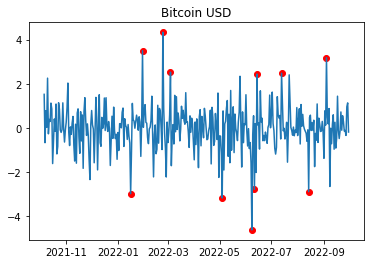

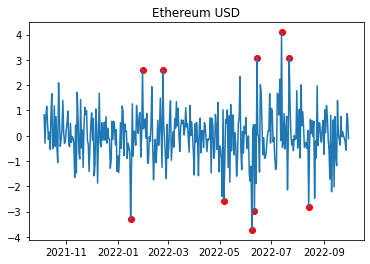

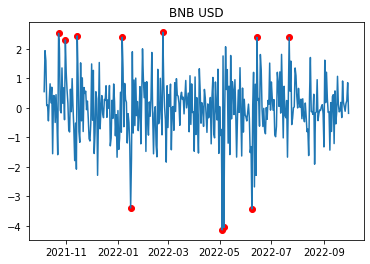

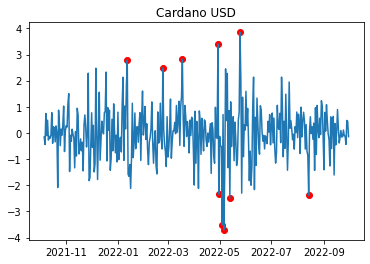

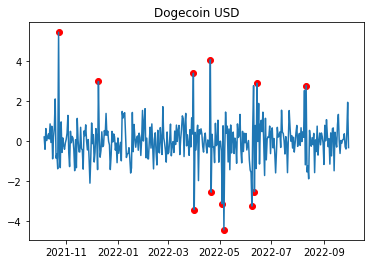

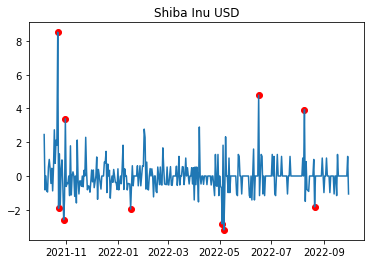

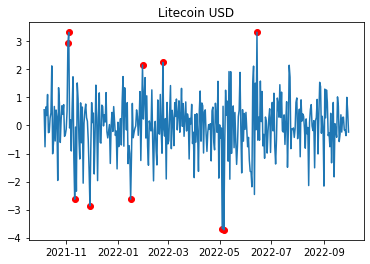

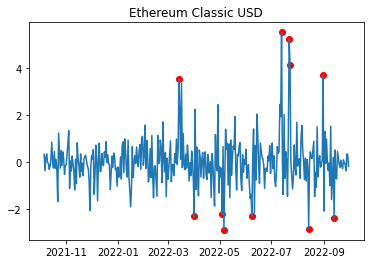

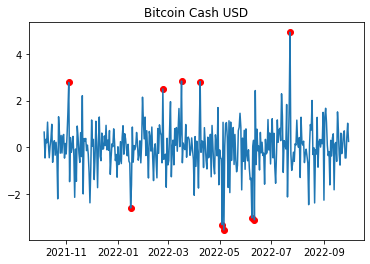

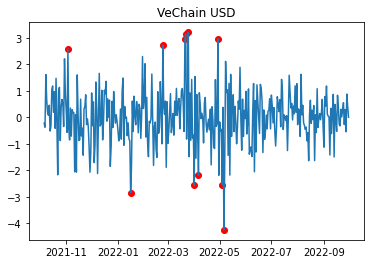

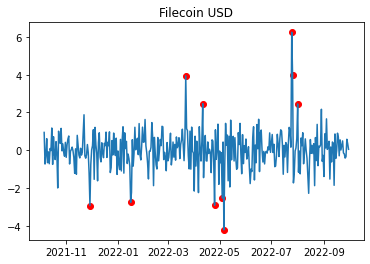

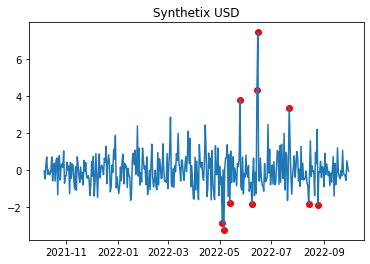

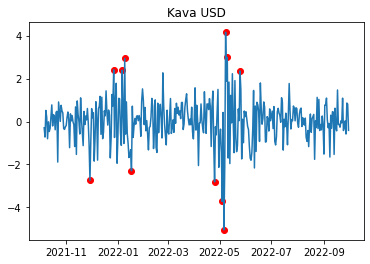

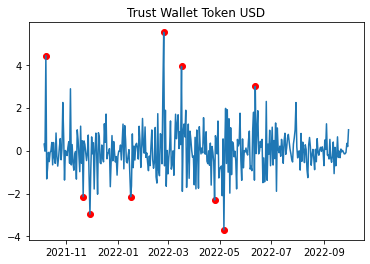

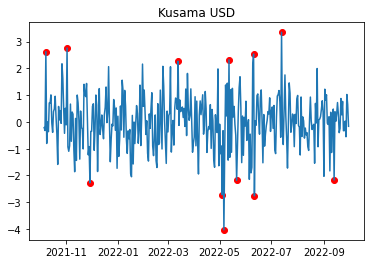

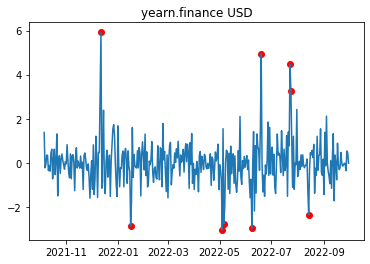

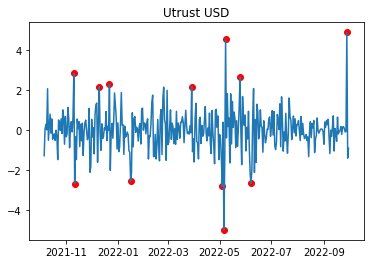

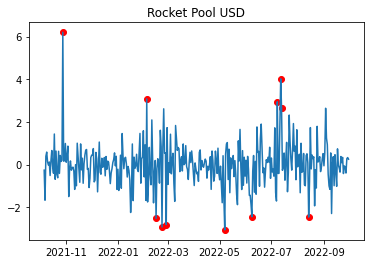

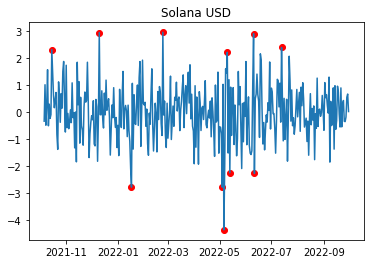

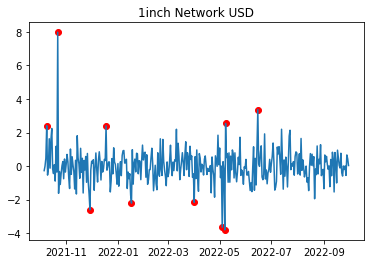

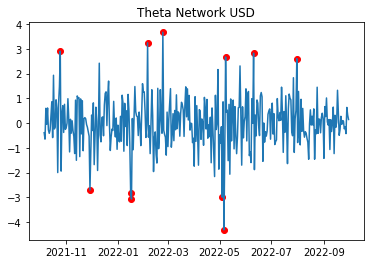

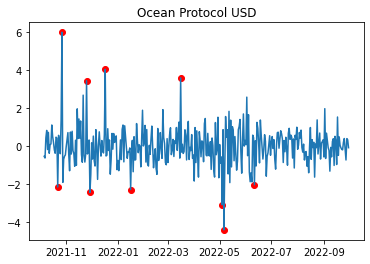

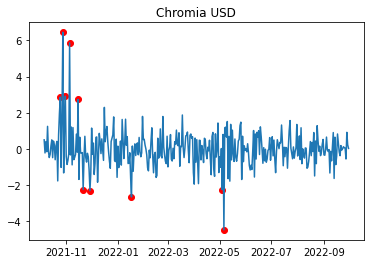

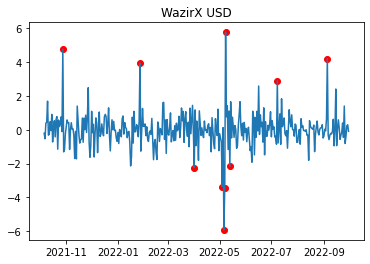

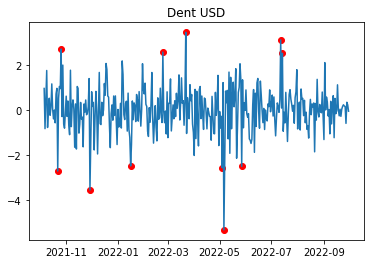

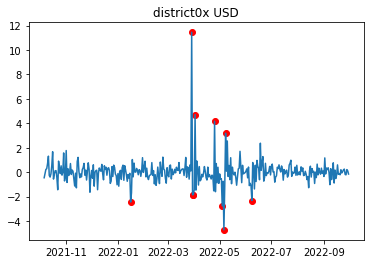

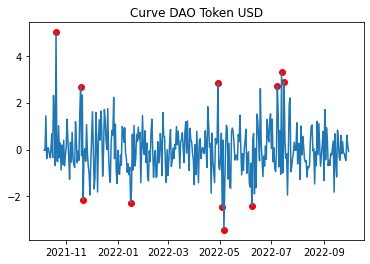

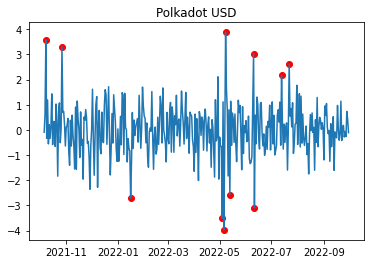

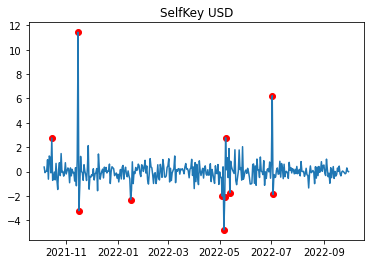

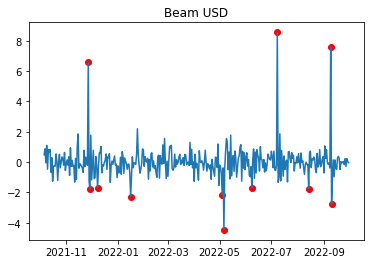

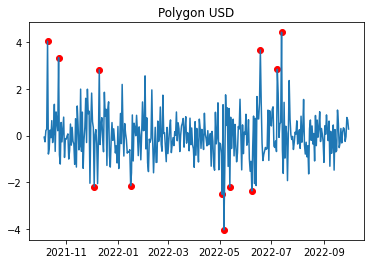

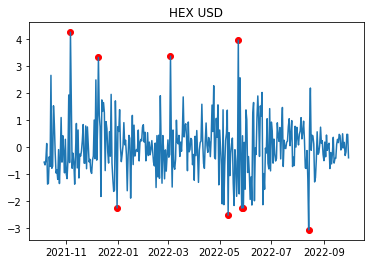

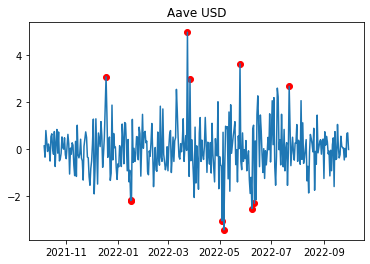

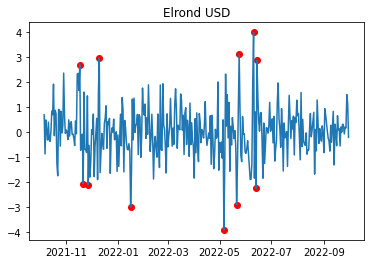

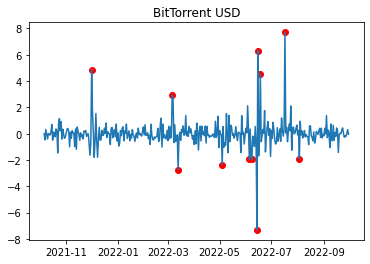

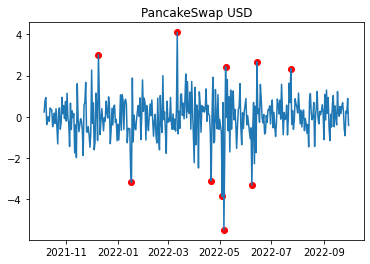

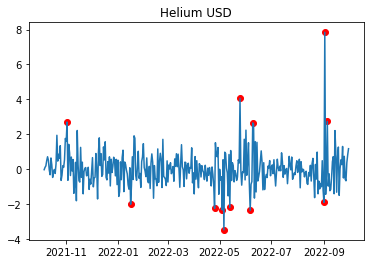

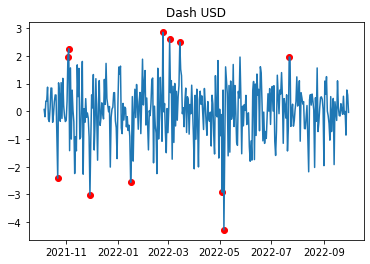

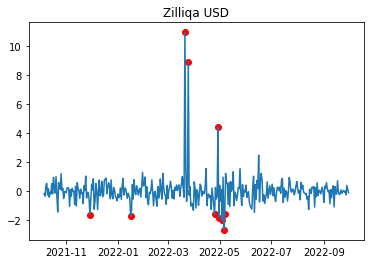

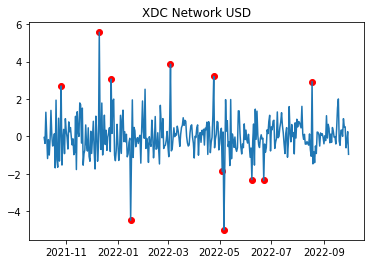

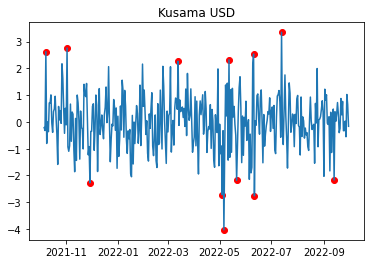

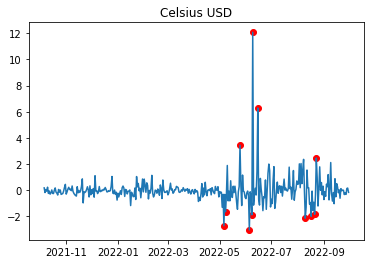

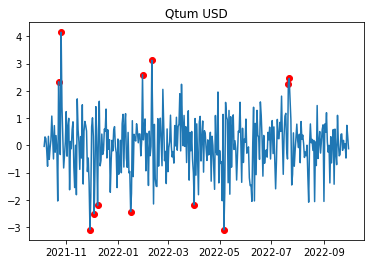

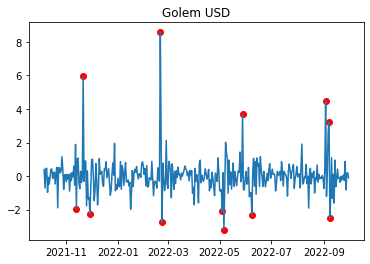

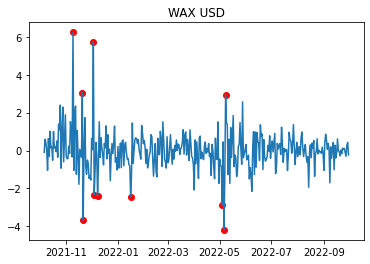

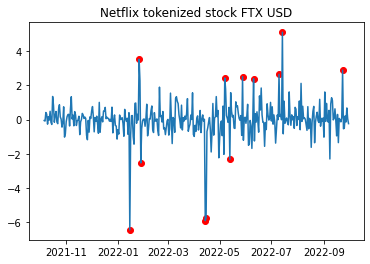

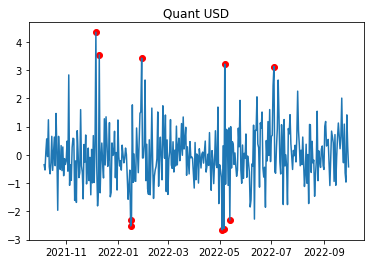

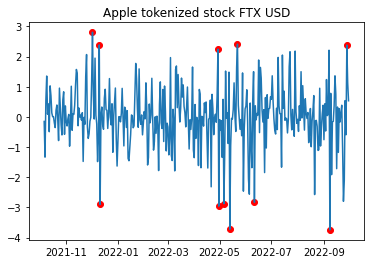

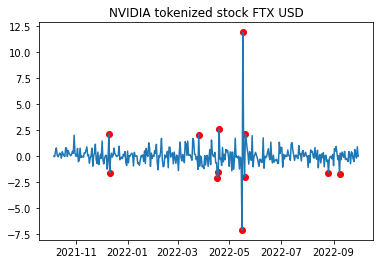

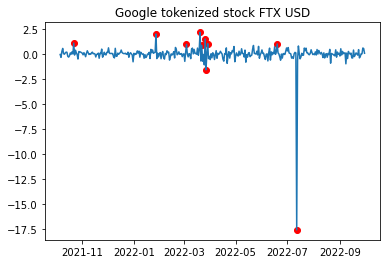

In [399]:
find_and_remake_anomalies(tickers_scaled_2_df)

# With new data, let's look at the clustering methods used in the previous stages:
1. Hiearchical alorigth (DTW);
2. KMeans + feature extractors.

# Hiearchical alorigth (DTW) (clasetisation using the DTW Distance method)

In [400]:
model = clustering.HierarchicalTree(dists_fun=dtw.distance_matrix_fast, dists_options={})
cluster_idx = model.fit(tickers_scaled_2_df.values)

DTAIDistance C-extension for Numpy is not available. Proceeding anyway.
 98%|█████████████████████████████████████████████████████████████████████████████▍ | 49/50 [00:00<00:00, 10083.45it/s]


Visualise the cluster distribution using a dendogram

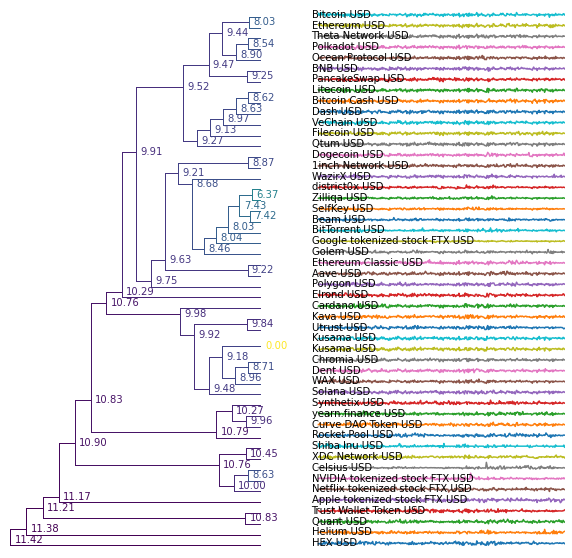

In [401]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
show_ts_label = lambda idx: tickers_scaled_2_df.index[idx]
model.plot(axes=ax, show_ts_label=show_ts_label,
           show_tr_label=True, ts_label_margin=-10,
           ts_left_margin=10, ts_sample_length=1)
plt.show()

# KMeans with the feature extractors

In [427]:
data=[]
for i in range(50):
    for j in range(360):
        data.append(tickers_scaled_2_df.iloc[i,j])
data = pd.DataFrame(data)
data['index_coin'] = np.repeat(range(50), 360)

extraction_settings_Comprehensive = ComprehensiveFCParameters()
extraction_settings_Minimal = MinimalFCParameters()
extraction_settings_Efficient = EfficientFCParameters()


X_Comprehensive = extract_features(data, column_id='index_coin', impute_function=impute,
                    default_fc_parameters=extraction_settings_Comprehensive)
X_Minimal = extract_features(data, column_id='index_coin', impute_function=impute,
                    default_fc_parameters=extraction_settings_Minimal)
X_Efficient = extract_features(data, column_id='index_coin', impute_function=impute,
                    default_fc_parameters=extraction_settings_Efficient)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:07<00:00,  2.42it/s]


In [403]:
X_Comprehensive = X_Comprehensive.dropna(axis=1)
X_Minimal = X_Minimal.dropna(axis=1)
X_Efficient = X_Efficient.dropna(axis=1)

  0%|          | 0/28 [00:00<?, ?it/s]

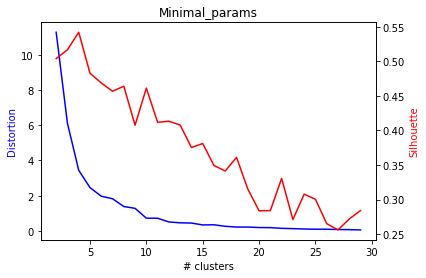

  0%|          | 0/28 [00:00<?, ?it/s]

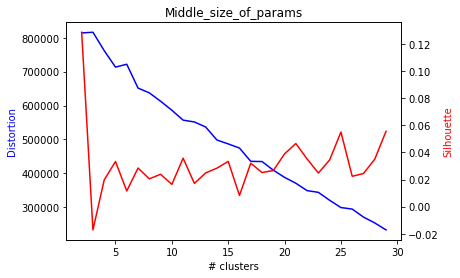

  0%|          | 0/28 [00:00<?, ?it/s]

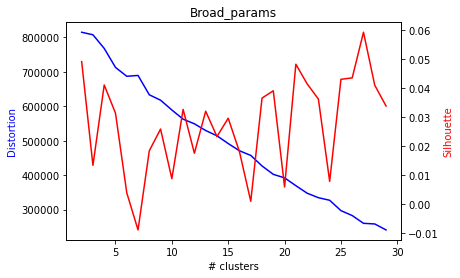

In [404]:
distortions = []
silhouette = []
K = range(2,30)
for feature_matrix, type_ in zip([X_Minimal, X_Efficient, X_Comprehensive], ['Minimal_params', 'Middle_size_of_params', 'Broad_params']):
    distortions = []
    silhouette = []
    for k in tqdm(K):
        kmeanModel = TimeSeriesKMeans(n_clusters=k)
        kmeanModel.fit(feature_matrix)
        distortions.append(kmeanModel.inertia_)
        silhouette.append(silhouette_score(feature_matrix, kmeanModel.labels_, metric="euclidean"))
        
    fig, ax1 = plt.subplots()
       
    plt.title(type_)
    ax2 = ax1.twinx()
    ax1.plot(K, distortions, 'b-')
    ax2.plot(K, silhouette, 'r-')
        
    ax1.set_xlabel('# clusters')
    ax1.set_ylabel('Distortion', color='b')
    ax2.set_ylabel('Silhouette', color='r')
      
    plt.show()

Function for visualisation of cluster distribution

In [405]:
def plot_cluster_tickers(current_cluster):
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/4)),
        4,
        figsize=(15, 3*int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)

    for index, (_, row) in enumerate(current_cluster.iterrows()):
        ax[index].plot(row.iloc[5:-1])
        ax[index].set_title(f"{row.shortName}")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

In [422]:
full_ticker_df_1 = tickers_scaled_2_df.iloc[:,:-4]
full_ticker_df_1.insert(0, 'shortName', tickers_scaled_2_df.index)

full_ticker_df_2 = tickers_scaled_2_df.iloc[:,:-4]
full_ticker_df_2.insert(0, 'shortName', tickers_scaled_2_df.index)

full_ticker_df_3 = tickers_scaled_2_df.iloc[:,:-4]
full_ticker_df_3.insert(0, 'shortName', tickers_scaled_2_df.index)

### Train the model with regard to the optimal number of clusters obtained at the previous step for each set of feature extractors

In [423]:
n_clusters = [5,3,7]

ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters[0], metric="euclidean", n_jobs=6, max_iter=10)
ts_kmeans.fit(X_Minimal)
full_ticker_df_1['cluster_min_feature'] = ts_kmeans.predict(X_Minimal)

ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters[1], metric="euclidean", n_jobs=6, max_iter=10)
ts_kmeans.fit(X_Efficient)
full_ticker_df_2['cluster_mid_feature'] = ts_kmeans.predict(X_Efficient)

ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters[2], metric="euclidean", n_jobs=6, max_iter=10)
ts_kmeans.fit(X_Comprehensive)
full_ticker_df_3['cluster_broad_feature'] = ts_kmeans.predict(X_Comprehensive)

Make a visualisation of the distribution of assets into clusters

                          Cluster name: cluster_min_feature
                          Cluster number: 0


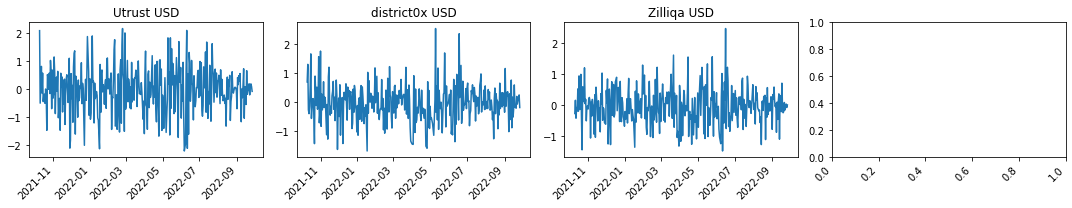

                          Cluster name: cluster_min_feature
                          Cluster number: 1


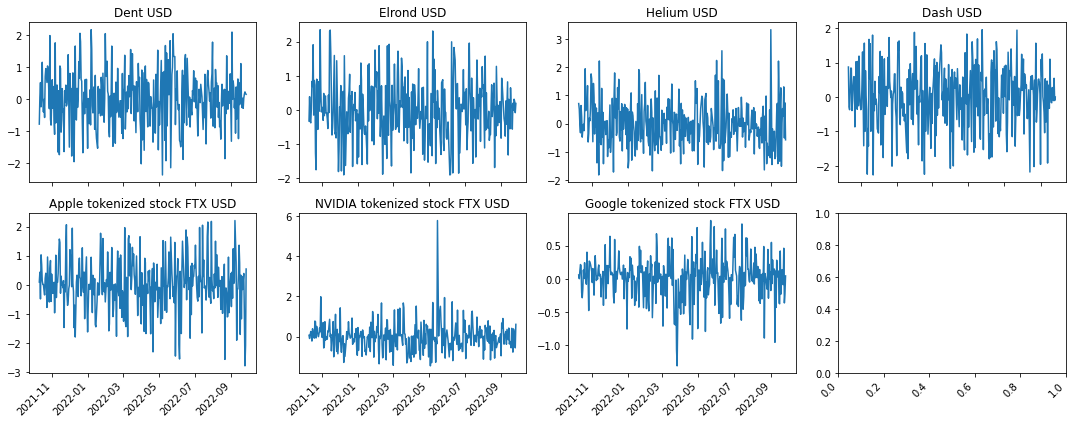

                          Cluster name: cluster_min_feature
                          Cluster number: 2


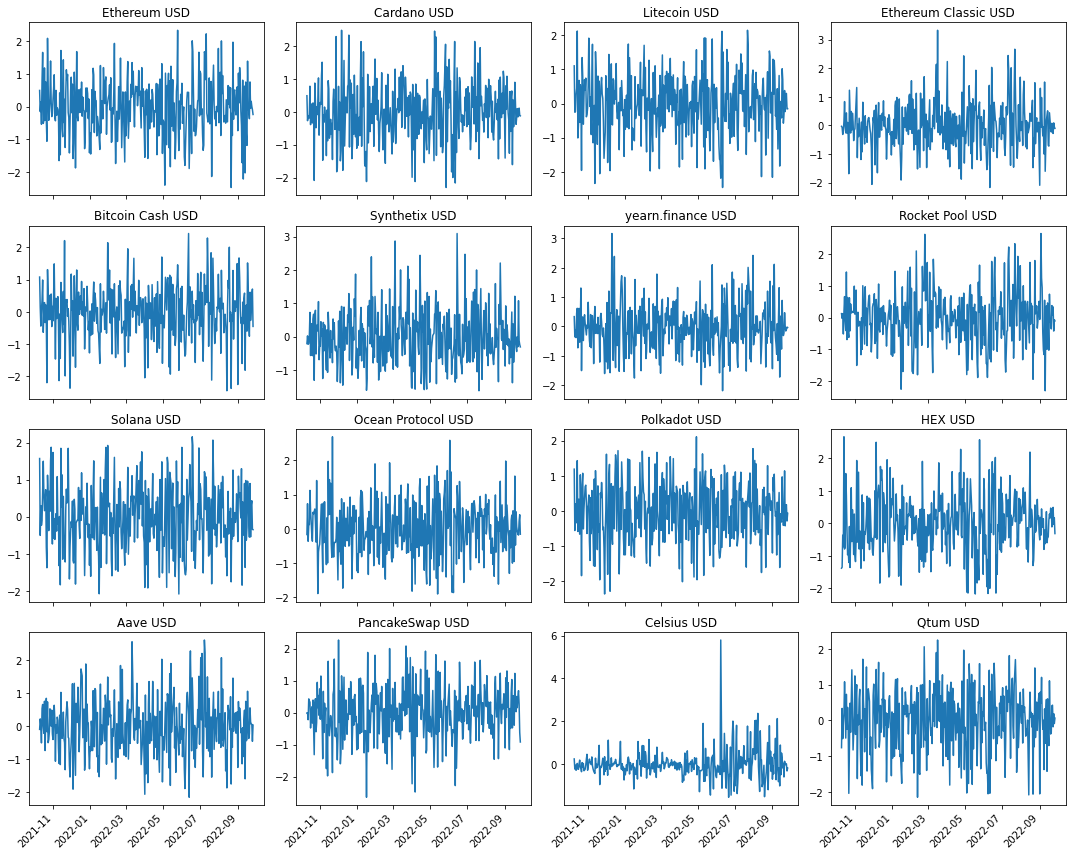

                          Cluster name: cluster_min_feature
                          Cluster number: 3


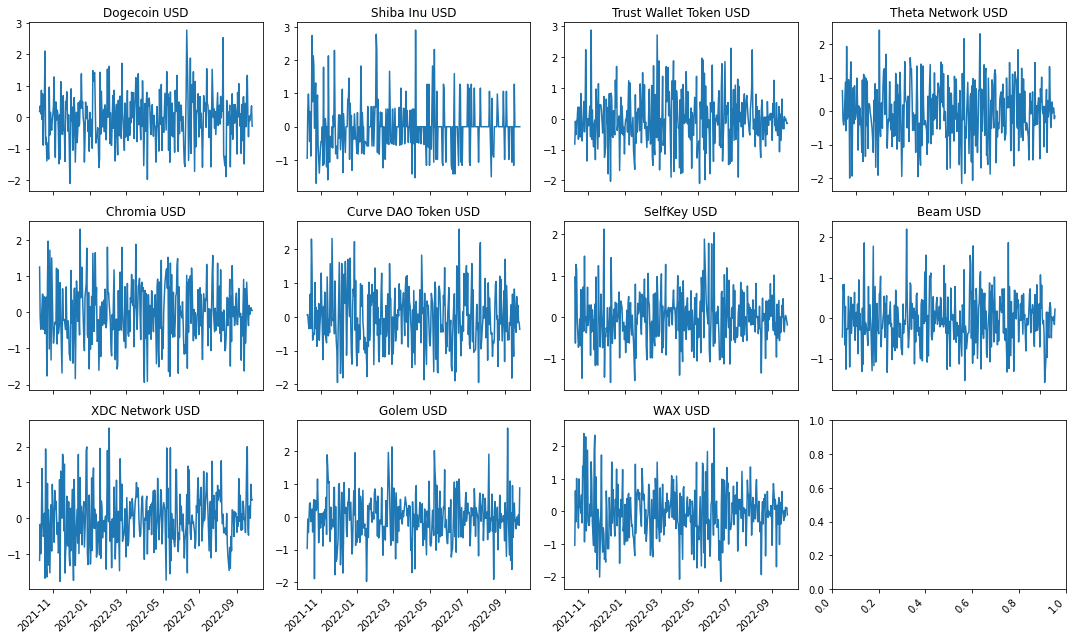

                          Cluster name: cluster_min_feature
                          Cluster number: 4


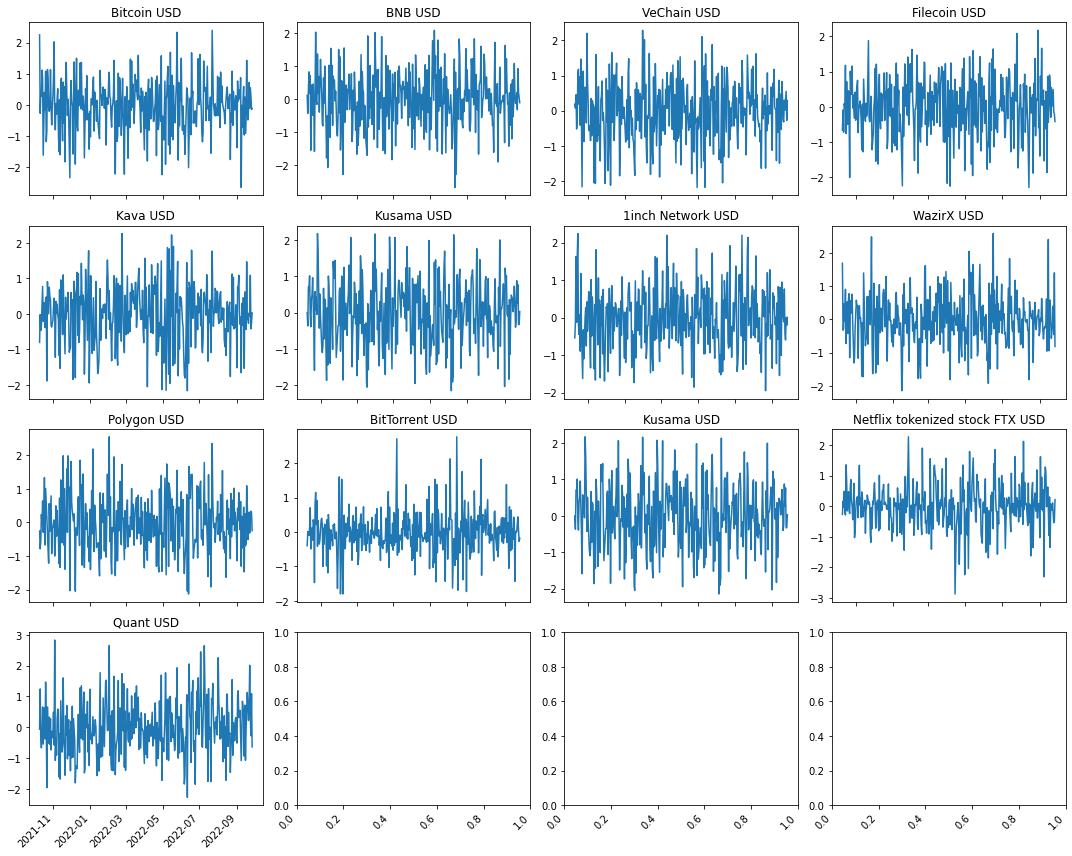

                          Cluster name: cluster_mid_feature
                          Cluster number: 0


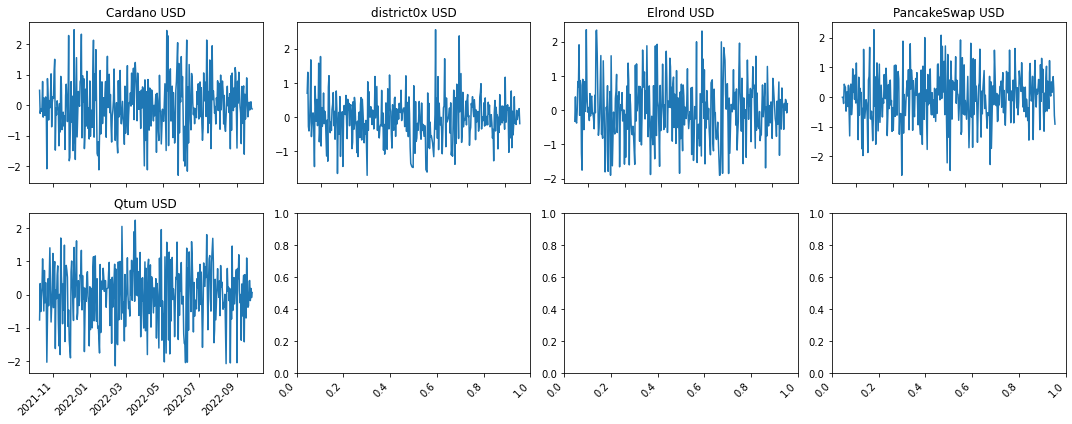

                          Cluster name: cluster_mid_feature
                          Cluster number: 1


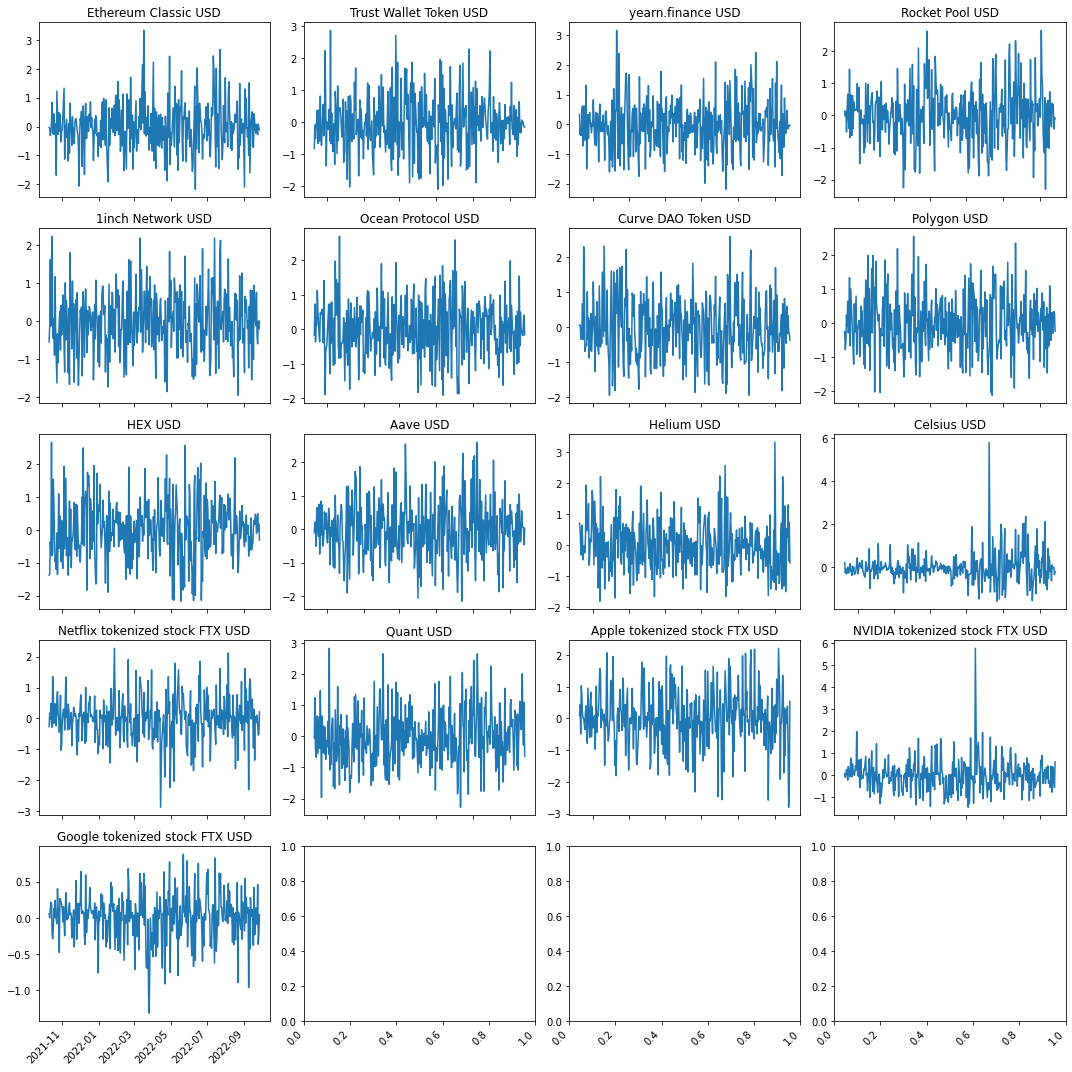

                          Cluster name: cluster_mid_feature
                          Cluster number: 2


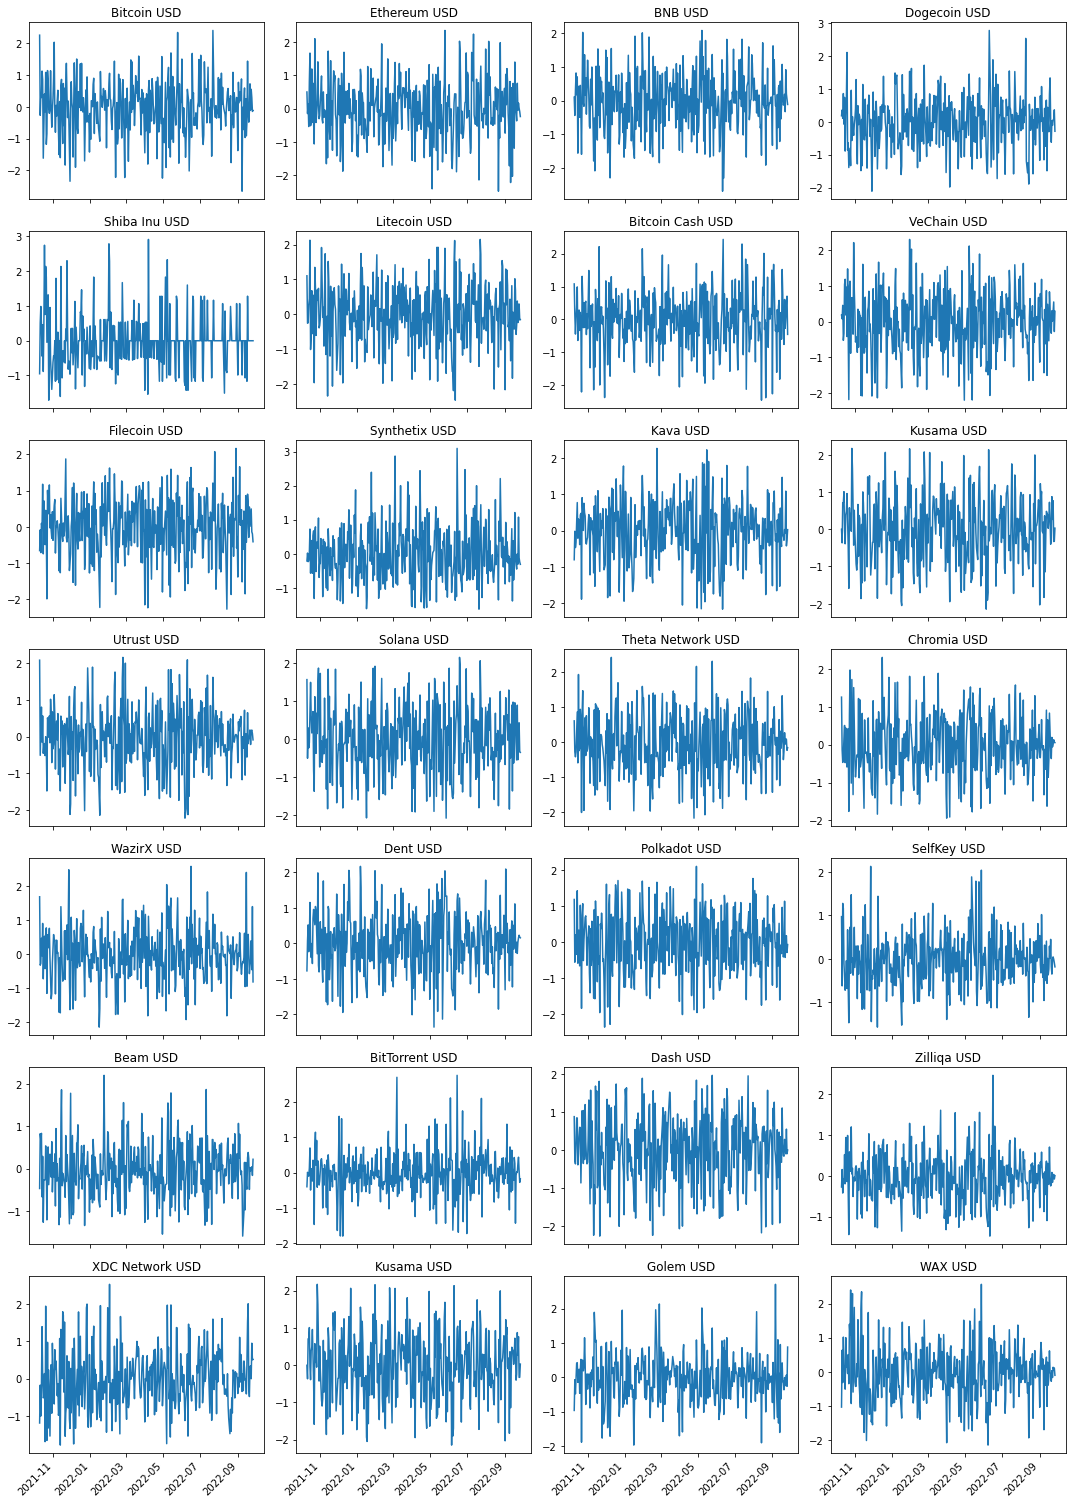

                          Cluster name: cluster_broad_feature
                          Cluster number: 0


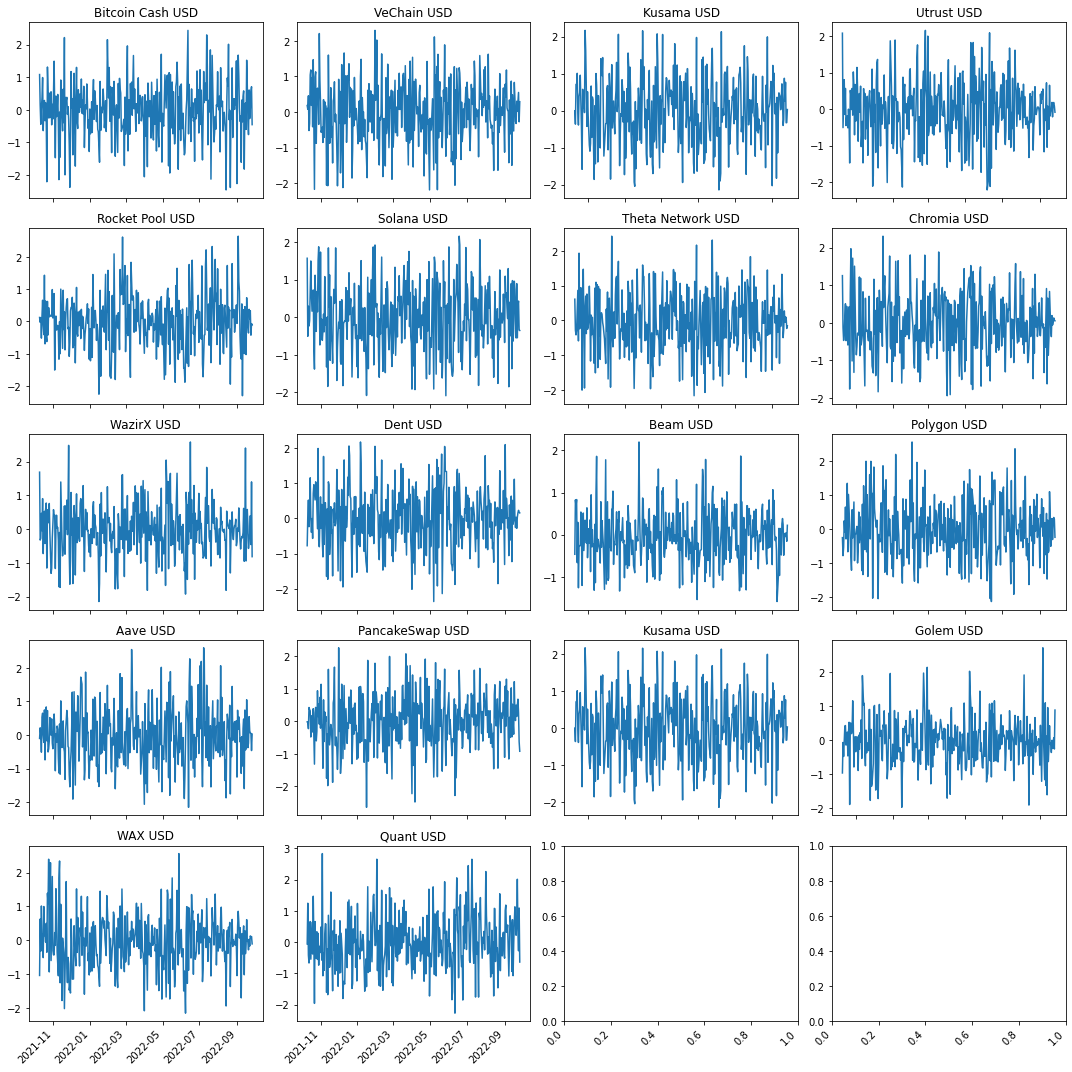

                          Cluster name: cluster_broad_feature
                          Cluster number: 1


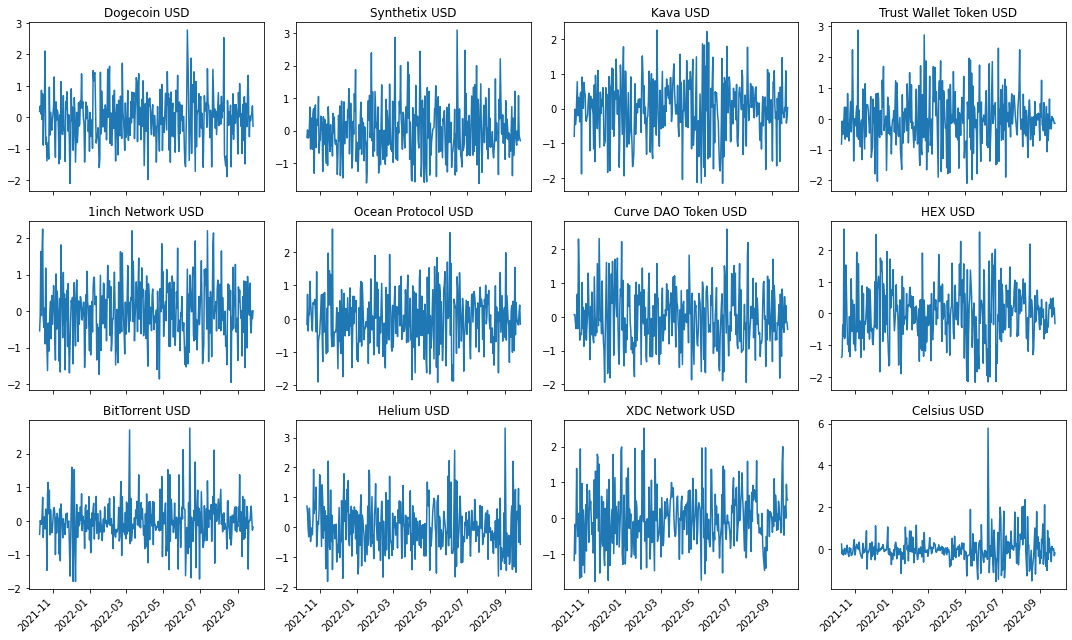

                          Cluster name: cluster_broad_feature
                          Cluster number: 2


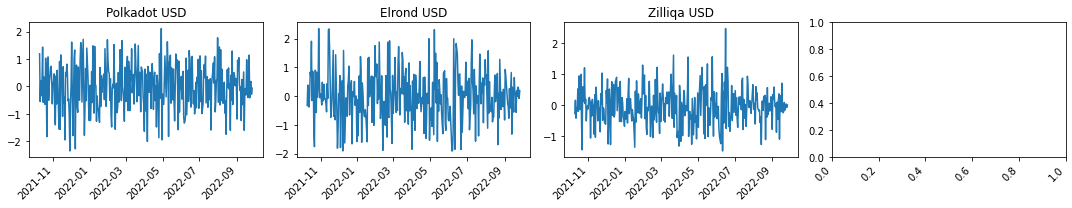

                          Cluster name: cluster_broad_feature
                          Cluster number: 3


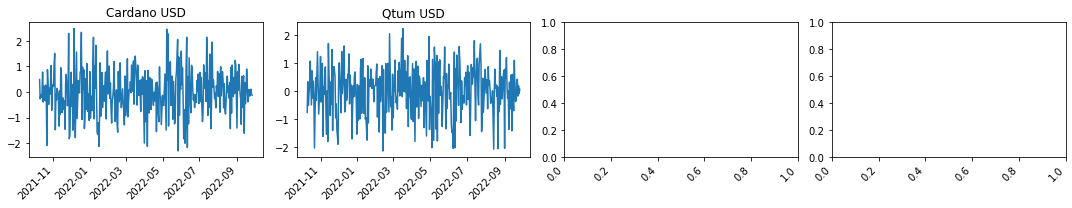

                          Cluster name: cluster_broad_feature
                          Cluster number: 4


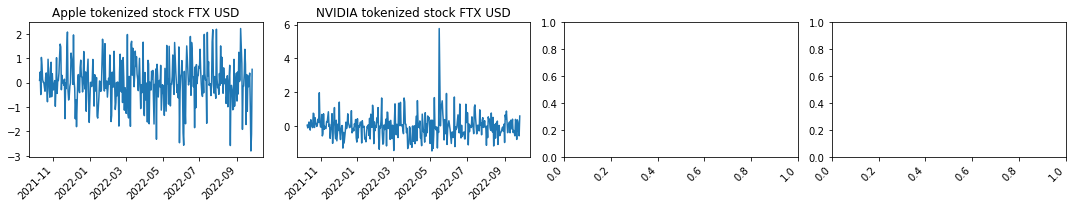

                          Cluster name: cluster_broad_feature
                          Cluster number: 5


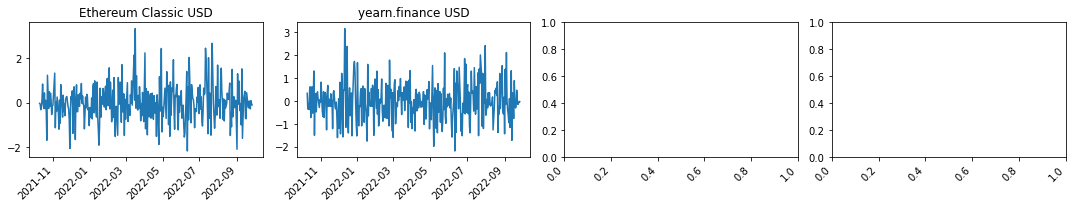

                          Cluster name: cluster_broad_feature
                          Cluster number: 6


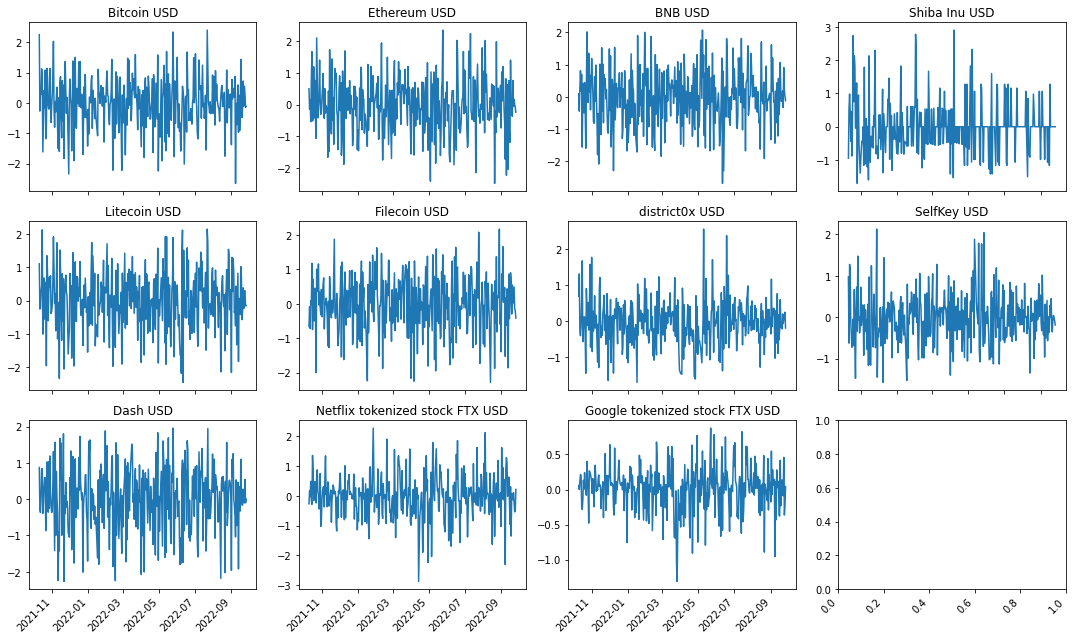

In [424]:
figsize = (10,10)
i=0
for dframe, name in zip([full_ticker_df_1, full_ticker_df_2, full_ticker_df_3], ['cluster_min_feature','cluster_mid_feature', 'cluster_broad_feature']):
    
    for cluster in range(n_clusters[i]):
        print(f"                          Cluster name: {name}")
        print("=================================================================================")
        print(f"                          Cluster number: {cluster}")
        print("=================================================================================")
        plot_cluster_tickers(dframe[dframe[name]==cluster])
    print("=================================================================================")
    print("=================================================================================")
    print("=================================================================================")
    i=i+1


## Let's do another visualisation through PCA method (Principal Component Analysis)

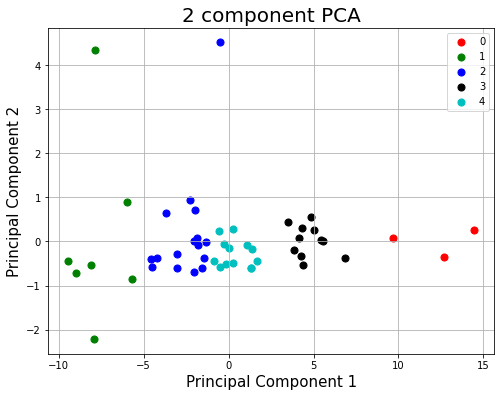

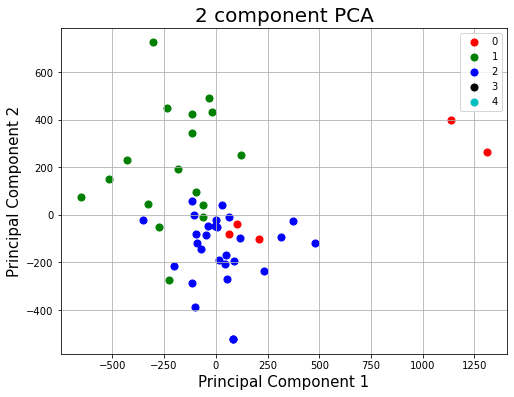

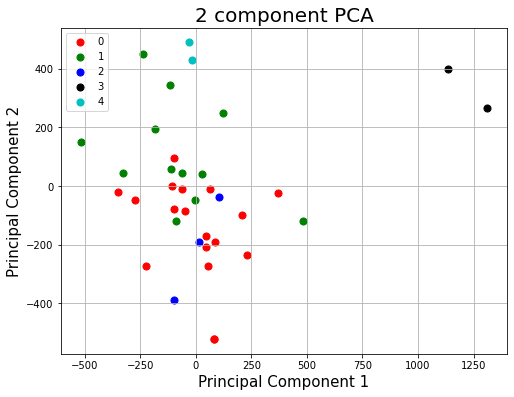

In [425]:
clusters_ts_X_feature_Min = full_ticker_df_1.cluster_min_feature.values
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_Minimal)
principalDf = pd.DataFrame(data = X_pca , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pd.DataFrame(clusters_ts_X_feature_Min, columns=['Cluster'])], axis = 1)

clusters_ts_X_feature_Mid = full_ticker_df_2.cluster_mid_feature.values
pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_Efficient)
principalDf_2 = pd.DataFrame(data = X_pca_2 , columns = ['principal component 1', 'principal component 2'])
final2Df = pd.concat([principalDf_2, pd.DataFrame(clusters_ts_X_feature_Mid, columns=['Cluster'])], axis = 1)

clusters_ts_X_feature_Broad = full_ticker_df_3.cluster_broad_feature.values
pca_3 = PCA(n_components=2)
X_pca_3 = pca_3.fit_transform(X_Comprehensive)
principalDf_3 = pd.DataFrame(data = X_pca_3 , columns = ['principal component 1', 'principal component 2'])
final3Df = pd.concat([principalDf_3, pd.DataFrame(clusters_ts_X_feature_Broad, columns=['Cluster'])], axis = 1)
def plot_pca(finalDf):
    fig = plt.figure(figsize = (8,6))
    ax = fig.add_subplot(1,1,1) 
    #fig, ax = plt.subplots()
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    targets = [0, 1, 2, 3, 4]
    colors = ['r', 'g', 'b', 'k', 'c']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['Cluster'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                  , finalDf.loc[indicesToKeep, 'principal component 2']
                  , c = color
                  , s = 50)
    ax.legend(targets)
    ax.grid()
plot_pca(finalDf)
plot_pca(final2Df)
plot_pca(final3Df)

# Conclusion:
1. The work done helped to clean the data from the outliers. 
2. More effective clusters for crypto asset distribution were obtained.